In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import itertools
import collections
import nltk
from nltk.corpus import stopwords
import re
import networkx

import warnings
warnings.filterwarnings("ignore")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [2]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/joeye/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('Data/USvideos.csv')
df.head(15)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
5,gHZ1Qz0KiKM,17.14.11,2 Weeks with iPhone X,iJustine,28,2017-11-13T19:07:23.000Z,"ijustine|""week with iPhone X""|""iphone x""|""appl...",119180,9763,511,1434,https://i.ytimg.com/vi/gHZ1Qz0KiKM/default.jpg,False,False,False,Using the iPhone for the past two weeks -- her...
6,39idVpFF7NQ,17.14.11,Roy Moore & Jeff Sessions Cold Open - SNL,Saturday Night Live,24,2017-11-12T05:37:17.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",2103417,15993,2445,1970,https://i.ytimg.com/vi/39idVpFF7NQ/default.jpg,False,False,False,Embattled Alabama Senate candidate Roy Moore (...
7,nc99ccSXST0,17.14.11,5 Ice Cream Gadgets put to the Test,CrazyRussianHacker,28,2017-11-12T21:50:37.000Z,"5 Ice Cream Gadgets|""Ice Cream""|""Cream Sandwic...",817732,23663,778,3432,https://i.ytimg.com/vi/nc99ccSXST0/default.jpg,False,False,False,Ice Cream Pint Combination Lock - http://amzn....
8,jr9QtXwC9vc,17.14.11,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,1,2017-11-13T14:00:23.000Z,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za...",826059,3543,119,340,https://i.ytimg.com/vi/jr9QtXwC9vc/default.jpg,False,False,False,"Inspired by the imagination of P.T. Barnum, Th..."
9,TUmyygCMMGA,17.14.11,Why the rise of the robots won’t mean the end ...,Vox,25,2017-11-13T13:45:16.000Z,"vox.com|""vox""|""explain""|""shift change""|""future...",256426,12654,1363,2368,https://i.ytimg.com/vi/TUmyygCMMGA/default.jpg,False,False,False,"For now, at least, we have better things to wo..."


In [26]:
df.groupby('category_id').sum()['views'].sort_values()

category_id
43       51501058
29      168941392
19      343557084
2       520690717
15      764651989
27     1180629990
25     1473765704
20     2141218625
28     3487756816
26     4078545064
17     4404456673
22     4917191726
23     5117426208
1      7284156721
24    20604388195
10    40132892190
Name: views, dtype: int64

In [4]:
df.shape

(40949, 16)

In [56]:
all_tags = [tag for tag in df['tags'].str.split(pat="|", expand= True).stack().reset_index(drop = True)]

In [57]:
all_tags[:5]

['SHANtell martin',
 'last week tonight trump presidency',
 '"last week tonight donald trump"',
 '"john oliver trump"',
 '"donald trump"']

In [8]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [59]:
all_tags_no_urls = [remove_url(tag) for tag in all_tags]
all_tags_no_urls[:5]

['SHANtell martin',
 'last week tonight trump presidency',
 'last week tonight donald trump',
 'john oliver trump',
 'donald trump']

In [60]:
words_in_tag = [tag.lower().split() for tag in all_tags_no_urls]
words_in_tag[:2]

[['shantell', 'martin'], ['last', 'week', 'tonight', 'trump', 'presidency']]

In [63]:
tags_nsw = [[word for word in tag_words if not word in stop_words]
              for tag_words in words_in_tag]
tags_nsw[:2]

[['shantell', 'martin'], ['last', 'week', 'tonight', 'trump', 'presidency']]

In [64]:
all_words_nsw = list(itertools.chain(*tags_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('video', 8355),
 ('makeup', 8048),
 ('funny', 7323),
 ('new', 7097),
 ('2018', 6538),
 ('music', 6488),
 ('show', 6020),
 ('news', 5860),
 ('food', 4826),
 ('comedy', 4768),
 ('trailer', 4609),
 ('youtube', 4444),
 ('movie', 4415),
 ('best', 4073),
 ('live', 3736)]

In [65]:
len(counts_nsw)

23294

In [91]:
counts_nsw['video']

8355

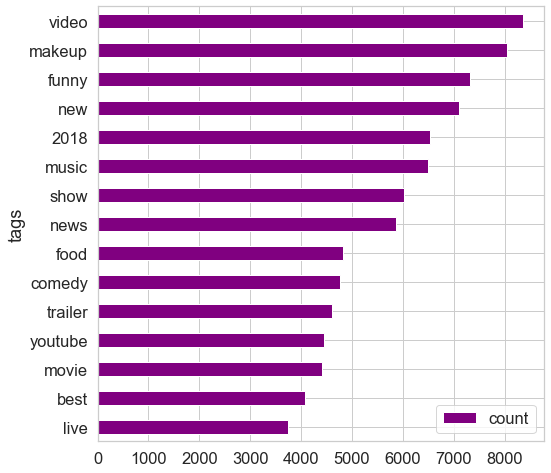

In [94]:
clean_tags_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['tags', 'count'])
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tags_nsw.sort_values(by='count').plot.barh(x='tags',
                      y='count',
                      ax=ax,
                      color="purple")

# ax.set_title("Common Tags Found in Trending Youtube Videos")

plt.savefig('tag_count.png', dpi = 300)
plt.show();

In [12]:
def plot_tags(df, color):
    all_tags = [tag for tag in df['tags'].str.split(pat="|", expand= True).stack().reset_index(drop = True)]
    all_tags_no_urls = [remove_url(tag) for tag in all_tags]
    words_in_tag = [tag.lower().split() for tag in all_tags_no_urls]
    tags_nsw = [[word for word in tag_words if not word in stop_words]
                  for tag_words in words_in_tag]
    all_words_nsw = list(itertools.chain(*tags_nsw))
    counts_nsw = collections.Counter(all_words_nsw)
    clean_tags_nsw = pd.DataFrame(counts_nsw.most_common(15),
                                 columns=['tags', 'count'])
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot horizontal bar graph
    clean_tags_nsw.sort_values(by='count').plot.barh(x='tags',
                          y='count',
                          ax=ax,
                          color=color)

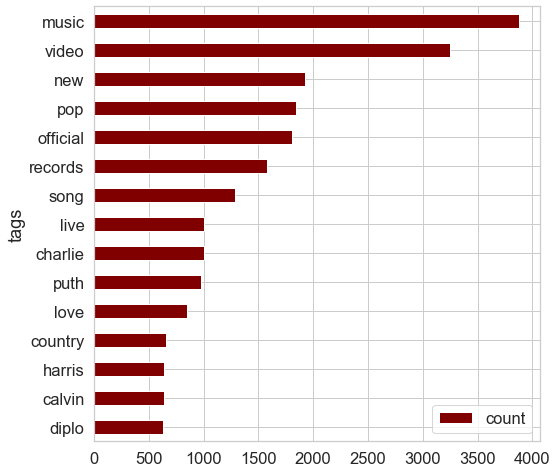

In [30]:
# plot for music
df_music = df[df['category_id'] == 10]
plot_tags(df_music,'maroon')
plt.savefig('music_tag.png', dpi = 300, bbox_inches='tight')
plt.show();

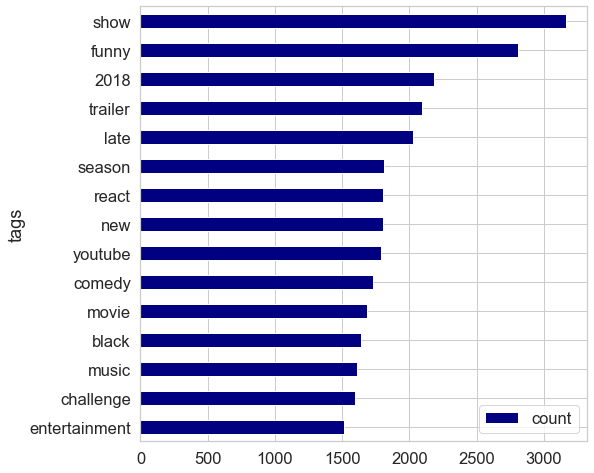

In [31]:
# plot for entertainment
df_enter = df[df['category_id'] == 24]
plot_tags(df_enter,'navy')
plt.savefig('entertain_tag.png', dpi = 300, bbox_inches='tight')
plt.show();

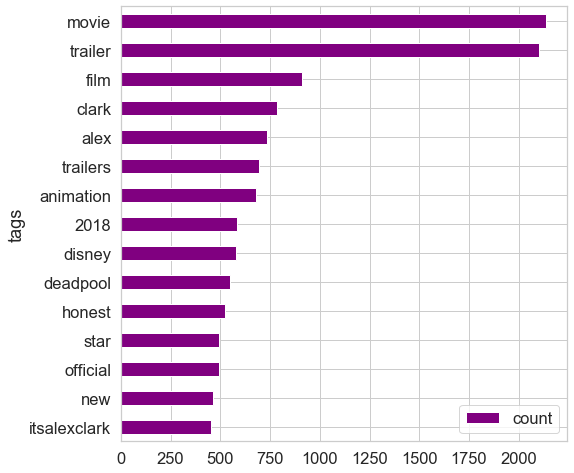

In [32]:
# plot for film & animation
df_film = df[df['category_id'] == 1]
plot_tags(df_film, 'purple')
plt.savefig('film_tag.png', dpi = 300, bbox_inches='tight')
plt.show();